<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#3.1-MNIST" data-toc-modified-id="3.1-MNIST-1">3.1 MNIST</a></span></li><li><span><a href="#3.2-이진-분류기-훈련" data-toc-modified-id="3.2-이진-분류기-훈련-2">3.2 이진 분류기 훈련</a></span></li><li><span><a href="#3.3-성능-측정" data-toc-modified-id="3.3-성능-측정-3">3.3 성능 측정</a></span><ul class="toc-item"><li><span><a href="#교차-검증을-사용한-정확도-측정" data-toc-modified-id="교차-검증을-사용한-정확도-측정-3.1">교차 검증을 사용한 정확도 측정</a></span></li><li><span><a href="#교차-검증-기능-직접-구현하기" data-toc-modified-id="교차-검증-기능-직접-구현하기-3.2"><code>교차 검증 기능 직접 구현하기</code></a></span></li><li><span><a href="#오차-행렬" data-toc-modified-id="오차-행렬-3.3">오차 행렬</a></span></li><li><span><a href="#정밀도와-재현율" data-toc-modified-id="정밀도와-재현율-3.4">정밀도와 재현율</a></span></li><li><span><a href="#정밀도/재현율-트레이드오프" data-toc-modified-id="정밀도/재현율-트레이드오프-3.5">정밀도/재현율 트레이드오프</a></span></li></ul></li></ul></div>

## 3.1 MNIST

MNIST 데이터셋은 학습용으로 아주 많이 사용되기 때문에 러신러닝의 "Hello World" 라고 합니다.

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object),
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixel49',
  'pixel50',
  'pixel51',
  '

사이킷런에서 읽어들인 데이터셋들은 일반적으로 비숫한 딕셔너리 구조를 가지고 있습니다.

- 데이터셋을 설명하는 **`DESCR`** 키
- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 **`data`** 키
- 레이블 배열을 담고 있는 **`target`** 키

In [2]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

`데이터를 더 자세히 조사하기 전에 항상 테스트 세트를 만들고 따로 떼어놓아야합니다.`<br>
MNIST 데이터셋은 이미 훈련 세트(앞쪽 60,000개)와 데스트 세트(뒤쪽 10,000개)로 나누어 놓았습니다.

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

`훈련 세트를 섞어서 모든 교차 검증 폴드가 비슷해지도록 만들겠습니다.` <br>
시계열 데이터의 경우 데이터를 섞는 것이 좋지 않습니다.

In [5]:
import numpy as np

shuffle_index = np.random.permutation(60000)    # 6만개의 무작위 인덱스 값을 생성
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [6]:
np.where(y_train == '5')[0][:10]    # "5"가 있는 인덱스 찾기

array([ 0,  1, 15, 35, 39, 65, 68, 69, 77, 85])

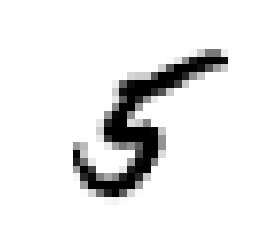

In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X_train[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis("off")
plt.show()

In [9]:
# 실제 레이블 확인
y_train[0]

'5'

## 3.2 이진 분류기 훈련

"5"와 "5 아님" 두 개의 클래스를 구분하는 이진 분류기(binary classifier)를 만들어 보겠습니다.

In [10]:
y_train_5 = (y_train == '5')    # '5'는 True, 다른 숫자는 모두 False
y_test_5 = (y_test == '5')

In [11]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

- 확률적 경사 하강법(Stochastic Gradient Descent) 분류기는 매우 큰 데이터셋을 효율적으로 처리하는 장점이 있습니다.<br>
   SGD가 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문입니다. (그래서 SGD가 온라인 학습에 잘 들어맞습니다.)

In [12]:
sgd_clf.predict([some_digit])    # 위에서 확인한 "5"을 정확인 예측하면 True

array([ True])

## 3.3 성능 측정

### 교차 검증을 사용한 정확도 측정

사이킷런의 cross_val_score() 함수로 폴드가 3개인 K-겹 교차 검증을 사용해 SGD 모델을 평가해보겠습니다.<br>
K-겹 교차 검증은 훈련 세트를 K개(여기서는 3개)의 폴드로 나누고, <br>
각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용합니다.

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95705, 0.95435, 0.9389 ])

- 95% 정확도는 매우 높은 것으로 보입니다.<br>
   모든 이미지를 "5 아님" 클래스로 분류하는('5'를 하나도 맞추지 못하는) 더미 분류기를 만들어서 정확도를 비교해보겠습니다.

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.908  , 0.9136 , 0.90735])

- '5'를 하나도 맞추지 못해도 정확도가 90% 입니다. 이미지의 10% 정도만 '5' 이기 때문입니다.<br>
   `이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여 줍니다.`<br>
   특히, 불균형 한 데이터셋(즉, 어떤 클래스가 다른 것보다 월등히 많은 경우)을 다룰 때 더욱 그렇습니다.

### `교차 검증 기능 직접 구현하기`

사이킷런에서 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 필요가 있는 경우 아래와 같이 직접 구현하면 됩니다.

StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행 합니다.<br>
매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만듭니다.<br>
그런 다음 올바른 예측의 수를 세어 정확한 예측의 비율을 출력합니다.

다음 코드는 **`cross_val_score()`** 함수와 거의 같은 작업을 수행하고 동일한 결과를 출력 합니다.

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95705
0.95435
0.9389


### 오차 행렬

**`분류기의 성능을 평가하는 더 좋은 방법은 오차 행렬(confusion matrix)를 조사하는 것입니다.`**<br>
기본적인 아이디어는 클래스 A의 샘플이 클래스 B로 분류된 회수를 세는 것입니다.

오차 행렬을 만들려면 실제 타깃 값과 비교할 수 있도록 먼저 예측값을 만들어야 합니다.<br>
**`cross_val_predict()`** 함수는 K-겹 교차 검증을 수행하여, 각 테스트 폴드에서 얻은 예측을 반환 합니다.<br>
즉, 훈련 세트의 모든 샘플에 대해 깨끗한(훈련하는 동안 보지 못했던 데이터에 대한) 예측을 얻게 됩니다.

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

**`confusion_matrix()`** 함수를 사용해 오차 행렬을 만듭니다.

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53496,  1083],
       [ 1911,  3510]])

- 오차 행렬의 **행은 실제 클래스**를 나타내고, **열은 예측한 클래스**를 나타냅니다.
- 위 행렬의 첫번째 행은 "5 아님" 이미지(**음성 클래스, Negative Class**)에 대한 것으로,<br>
   53,496개를 "5 아님"으로 정확히 분류했고(**진짜 음성, True Negative**), <br>
   나머지 1,083개는 "5"라고 잘못 분류했습니다.(**거짓 양성, False Positive**)
- 두번째 행은 "5" 이미지(**양성 클래스, Positive Class**)에 대한 것으로, <br>
   1,911개를 "5 아님"으로 잘못 분류했고(**거짓 음성, False Negative**), <br>
   나머지 3,510개를 정확히 "5"라고 분류했습니다.(**진짜 양성, True Positive**)

![오차 행렬](./images/fig3-2.png)

In [21]:
y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)    # 완벽한 분류기라면 진짜 양성과 진짜 음성만 가지고 있음(주대각선만 0이 아닌 값이 됨)

array([[54579,     0],
       [    0,  5421]])

조금 더 요약된 지표가 필요할 때 살펴볼만한 것은 양성 예측의 정확도 입니다.<br>
이를 분류기의 **정밀도(Precision)** 라고 합니다.

$\text{정밀도} = \large \frac{TP}{TP + FP}$

- TP는 진짜 양성의 수, FP는 거짓 양성의 수
- 확실한 진짜 양성 하나만 True로 예측하고 나머지를 모드 False로 예측해도(즉, 다른 양성 샘플을 무시해도) 정밀도가 100%가 되는 문제가 있음

정밀도는 **재현율(Recall)** 이라는 또 다른 지표와 같이 사용하는 것이 일반적입니다.<br>
재현율은 분류기가 정확하게 감지한 양성 샘플의 비율로, **민감도(Sensitivity)** 또는 <br>
**진짜 양성 비율(True Positive Rate, TPR)** 이라고도 합니다.

$\text{재현율} = \large \frac{TP}{TP+FN}$

- FN은 거짓 음성의 수

### 정밀도와 재현율

사이킷런은 정밀도(**`precision_score()`**)와 재현율(**`recall_score()`**)을 포함하여 분류기의 지표를 계산하는 여러 함수를 제공합니다.

In [23]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7642064010450685

In [24]:
recall_score(y_train_5, y_train_pred)

0.6474820143884892

- 정밀도와 재현율을 보니, 정확도만 봤을 때에 비해 훌륭한 결과는 아닙니다.

정밀도와 재현율을 $F_1$ **점수(F1 Score)** 라고 하는 하나의 숫자로 만들어 관리할 때가 많습니다.<br>
$F_1$ 점수는 정밀도와 재현율의 **조화 평균(Harmonic Mean)** 입니다.

$$
   F_1 = \frac{2}{\frac{1}{\text{정밀도}} + \frac{1}{\text{재현율}}} = 
   2 \times \frac{\text{정밀도} \times \text{재현율}}{\text{정밀도} + \text{재현율}} = 
   \frac{TP}{TP + {\frac{FN + FP}{2}}}
$$

$F_1$ 점수의 일반화된 조화 평균 식은 다음과 같습니다.

$$
   F = \frac{1}{\frac{\alpha}{\text{정밀도}} + \frac{1 - \alpha}{\text{재현율}}} = 
   (\beta^2 + 1) \times \frac{\text{정밀도} \times \text{재현율}}{\beta^2 \times \text{정밀도} + \text{재현율}}
$$

$$
   \beta^2 = \frac{1 - \alpha}{\alpha}
$$

- $\beta$가 1보다 크면 재현율이 강조되고, 1보다 작으면 정밀도가 강조됩니다.
- $\beta$가 1일 때(즉, $\alpha$가 $\frac{1}{2}$ 일때)의 $F$ 점수를 $F_1$ 점수라고 합니다.

$F_1$ 점수를 계산하려면 **`f1_score()`** 함수를 호출하면 됩니다.

In [25]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7010185739964051

- 정밀도와 재현율이 비슷한 분류기에서는 $F_1$ 점수가 높습니다.<br>
하지만 상황에 따라 정밀도가 중요할 수도 있고, 재현율이 중요할 수도 있습니다.

### 정밀도/재현율 트레이드오프